<a href="https://colab.research.google.com/github/ram130849/Deep_Learning_Systems_Assignments/blob/main/TensorFlow/Ramki/E533_DLS_Assignment4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

P1: Network Compression Using SVD

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import os
from tensorflow.keras import Model,layers
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [3]:
mnist = tf.keras.datasets.mnist

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [5]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train/=255
x_test/=255

In [6]:
print(x_train.shape)

(60000, 28, 28)


In [7]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.Dense(1024,activation='relu'),
  tf.keras.layers.Dense(1024,activation='relu'),
  tf.keras.layers.Dense(1024,activation='relu'),
  tf.keras.layers.Dense(1024,activation='relu'),
  tf.keras.layers.Dense(10)
])

In [8]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 1024)              803840    
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_2 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_3 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_4 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_5 (Dense)             (None, 10)                1

In [9]:
model.compile(optimizer="adam", loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics="acc")

In [10]:
checkpoint_path = "/content/drive/MyDrive/DLS_DATA/assign4/cp-{epoch:02d}.hdf5"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [11]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [12]:
history = model.fit(
    x_train,
    y_train,
    epochs=30,
    batch_size=128,
    callbacks=[cp_callback])

Epoch 1/30
463/469 [============================>.] - ETA: 0s - loss: 0.2281 - acc: 0.9313
Epoch 1: saving model to /content/drive/MyDrive/DLS_DATA/assign4/cp-01.hdf5
469/469 [==============================] - 6s 8ms/step - loss: 0.2268 - acc: 0.9316
Epoch 2/30
463/469 [============================>.] - ETA: 0s - loss: 0.1033 - acc: 0.9707
Epoch 2: saving model to /content/drive/MyDrive/DLS_DATA/assign4/cp-02.hdf5
469/469 [==============================] - 4s 8ms/step - loss: 0.1031 - acc: 0.9707
Epoch 3/30
460/469 [============================>.] - ETA: 0s - loss: 0.0703 - acc: 0.9797
Epoch 3: saving model to /content/drive/MyDrive/DLS_DATA/assign4/cp-03.hdf5
469/469 [==============================] - 4s 8ms/step - loss: 0.0703 - acc: 0.9797
Epoch 4/30
461/469 [============================>.] - ETA: 0s - loss: 0.0572 - acc: 0.9838
Epoch 4: saving model to /content/drive/MyDrive/DLS_DATA/assign4/cp-04.hdf5
469/469 [==============================] - 4s 8ms/step - loss: 0.0572 - acc: 0.9

In [13]:
def compress_weights(weight):
    S, U, V = tf.linalg.svd(weight)
    S = tf.linalg.diag(S)
    V = tf.transpose(V)
    return S,U,V

In [14]:
S_list = []
U_list = []
V_list = []
B_list = []
for i in range(1,6):
    weights = model.layers[i].weights[0]
    # print(i,weights)
    bias = model.layers[i].bias.numpy()
    S,U,V = compress_weights(weights)
    S_list.append(S)
    U_list.append(U)
    V_list.append(V)
    B_list.append(bias)

In [15]:
rank_values = [10,20,50,100,200]
acc_val = []
for value in rank_values:
    W_1 = tf.matmul(tf.matmul(U_list[0][:, :value], S_list[0][:value, :value]), V_list[0][:value, :])
    model.get_layer(index=1).set_weights([W_1,B_list[0]])
    W_2 = tf.matmul(tf.matmul(U_list[1][:, :value], S_list[1][:value, :value]), V_list[1][:value, :])
    model.get_layer(index=2).set_weights([W_2,B_list[1]])
    W_3 = tf.matmul(tf.matmul(U_list[2][:, :value], S_list[2][:value, :value]), V_list[2][:value, :])
    model.get_layer(index=3).set_weights([W_3,B_list[2]])
    W_4 = tf.matmul(tf.matmul(U_list[3][:, :value], S_list[3][:value, :value]), V_list[3][:value, :])
    model.get_layer(index=4).set_weights([W_4,B_list[3]])
    W_5 = tf.matmul(tf.matmul(U_list[4][:, :value], S_list[4][:value, :value]), V_list[4][:value, :])
    model.get_layer(index=5).set_weights([W_5,B_list[4]])
    acc_val.append(model.evaluate(x_test,y_test,verbose = 1)[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.1355 - acc: 0.9822


In [16]:
W_1 = tf.matmul(tf.matmul(U_list[0], S_list[0]), V_list[0])
W_2 = tf.matmul(tf.matmul(U_list[1], S_list[1]), V_list[1])
W_3 = tf.matmul(tf.matmul(U_list[2], S_list[2]), V_list[2])
W_4 = tf.matmul(tf.matmul(U_list[3], S_list[3]), V_list[3])
W_5 = tf.matmul(tf.matmul(U_list[4], S_list[4]), V_list[4])


model.get_layer(index=1).set_weights([W_1,B_list[0]])
model.get_layer(index=2).set_weights([W_2,B_list[1]])
model.get_layer(index=3).set_weights([W_3,B_list[2]])
model.get_layer(index=4).set_weights([W_4,B_list[3]])
model.get_layer(index=5).set_weights([W_5,B_list[4]])

acc_val.append(model.evaluate(x_test,y_test,verbose = 1)[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.1580 - acc: 0.9825


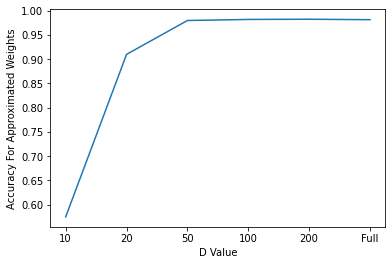

In [17]:
fig, ax = plt.subplots()
ax.plot(acc_val)
ax.set_ylabel("Accuracy For Approximated Weights")
ax.set_xlabel("D Value")
x = [0,10,20,50,100,200,'Full']
ax.set_xticklabels(x)
plt.show()

P2: Network Compression Using SVD

In [17]:
S1,U1,V1 = tf.linalg.svd(model.layers[1].weights[0])
S2,U2,V2 = tf.linalg.svd(model.layers[2].weights[0])
S3,U3,V3 = tf.linalg.svd(model.layers[3].weights[0])
S4,U4,V4 = tf.linalg.svd(model.layers[4].weights[0])
S5,U5,V5 = tf.linalg.svd(model.layers[5].weights[0])

rank = 20

s_1 = tf.linalg.diag(S1)[:rank, :rank]
s_2 = tf.linalg.diag(S2)[:rank, :rank]
s_3 = tf.linalg.diag(S3)[:rank, :rank]
s_4 = tf.linalg.diag(S4)[:rank, :rank]
s_5 = tf.linalg.diag(S5)[:rank, :rank]

v_1 = tf.transpose(V1)[:rank, :]
v_2 = tf.transpose(V2)[:rank, :]
v_3 = tf.transpose(V3)[:rank, :]
v_4 = tf.transpose(V4)[:rank, :]
v_5 = tf.transpose(V5)[:rank, :]


v_s1 = tf.matmul(s_1,v_1)
v_s2 = tf.matmul(s_2,v_2)
v_s3 = tf.matmul(s_3,v_3)
v_s4 = tf.matmul(s_4,v_4)
v_s5 = tf.matmul(s_5,v_5)

u_1 = U1[:, :rank]
u_2 = U2[:, :rank]
u_3 = U3[:, :rank]
u_4 = U4[:, :rank]
u_5 = U5[:, :rank]

B1 = model.layers[1].bias
B2 = model.layers[2].bias
B3 = model.layers[3].bias
B4 = model.layers[4].bias
B5 = model.layers[5].bias

In [19]:
print(u_1.shape)
print(v_1.shape)

(784, 20)
(20, 1024)


In [19]:
weights =[]
weights.append(u_1)
weights.append(v_s1)
weights.append(u_2)
weights.append(v_s2)
weights.append(u_3)
weights.append(v_s3)
weights.append(u_4)
weights.append(v_s4)
weights.append(u_5)
weights.append(v_s5)

In [20]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28)),

    tf.keras.layers.Dense(units=20),
    tf.keras.layers.Dense(units=1024,activation='relu'),

    tf.keras.layers.Dense(units=20),
    tf.keras.layers.Dense(units=1024,activation='relu'),

    tf.keras.layers.Dense(units=20),
    tf.keras.layers.Dense(units=1024,activation='relu'),

    tf.keras.layers.Dense(units=20),
    tf.keras.layers.Dense(units=1024,activation='relu'),

    tf.keras.layers.Dense(units=20),
    tf.keras.layers.Dense(units=1024,activation='relu'),
    
    tf.keras.layers.Dense(units=10,activation='softmax')
  ])

In [21]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 20)                15700     
                                                                 
 dense_7 (Dense)             (None, 1024)              21504     
                                                                 
 dense_8 (Dense)             (None, 20)                20500     
                                                                 
 dense_9 (Dense)             (None, 1024)              21504     
                                                                 
 dense_10 (Dense)            (None, 20)                20500     
                                                                 
 dense_11 (Dense)            (None, 1024)             

In [22]:
bias = [None]*10
bias[1] = B1
bias[3] = B2
bias[5] = B3
bias[7] = B4
bias[9] = B5
temp_bias = []
for i in range(1,len(model1.layers)-1):
    temp_bias.append(model1.layers[i].bias)
bias[0] = temp_bias[0]
bias[2] = temp_bias[2]
bias[4] = temp_bias[4]
bias[6] = temp_bias[6]
bias[8] = temp_bias[8]

In [23]:
for i in range(len(weights)):
  model1.layers[i+1].set_weights([weights[i],bias[i]])

In [24]:
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
               loss = tf.losses.SparseCategoricalCrossentropy(from_logits=False),
               metrics=['accuracy'])

In [25]:
history1 = model1.fit(x_train,y_train,epochs = 30, batch_size = 128 )

Epoch 1/30
469/469 [==============================] - 2s 4ms/step - loss: 0.4716 - accuracy: 0.8543
Epoch 2/30
469/469 [==============================] - 2s 4ms/step - loss: 0.0889 - accuracy: 0.9785
Epoch 3/30
469/469 [==============================] - 2s 4ms/step - loss: 0.0652 - accuracy: 0.9826
Epoch 4/30
469/469 [==============================] - 2s 4ms/step - loss: 0.0522 - accuracy: 0.9857
Epoch 5/30
469/469 [==============================] - 2s 4ms/step - loss: 0.0430 - accuracy: 0.9877
Epoch 6/30
469/469 [==============================] - 2s 4ms/step - loss: 0.0364 - accuracy: 0.9889
Epoch 7/30
469/469 [==============================] - 2s 4ms/step - loss: 0.0311 - accuracy: 0.9905
Epoch 8/30
469/469 [==============================] - 2s 4ms/step - loss: 0.0267 - accuracy: 0.9916
Epoch 9/30
469/469 [==============================] - 2s 4ms/step - loss: 0.0235 - accuracy: 0.9926
Epoch 10/30
469/469 [==============================] - 2s 4ms/step - loss: 0.0194 - accuracy: 0.9940

In [26]:
test_acc = model1.evaluate(x_test,y_test)
print("Test Accuracy:",test_acc[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.2778 - accuracy: 0.9802
Test Accuracy: 0.9801999926567078


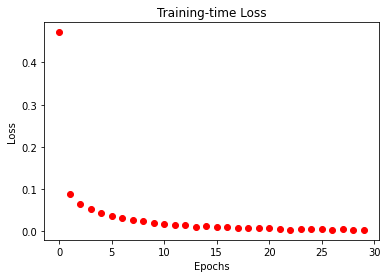

In [34]:
plt.plot(history1.history['loss'],'bo',color='red')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("Training-time Loss")
plt.show()

P3:  Network Compression Using SVD

P4: Speaker Verification

In [3]:
import gzip
import pickle
import random
from itertools import combinations,product

In [4]:
with open('/content/drive/MyDrive/DLS_DATA/assign4/training/hw4_trs.pkl', 'rb') as f:
    x_train = pickle.load(f)

In [5]:
print(x_train.shape)

(500, 16180)


In [6]:
y_train = np.zeros((500,1))
idx=0
for i in range(0,50):
    for j in range(0,10):
        y_train[idx]=i
        idx+=1
print(y_train.shape)

(500, 1)


In [7]:
with open('/content/drive/MyDrive/DLS_DATA/assign4/training/hw4_tes.pkl', 'rb') as f:
    x_test = pickle.load(f)

In [8]:
print(x_test.shape)

(200, 22631)


In [9]:
y_test = np.zeros((200,1))
idx=0
for i in range(0,20):
    for j in range(0,10):
        y_test[idx]=i
        idx+=1
print(y_test.shape)

(200, 1)


In [10]:
x_train_stft = np.zeros(shape=(500,45,513))
for i in range(x_train.shape[0]):
    x = x_train[i,:]
    X_complex = librosa.stft(x, n_fft=1024, hop_length=512)
    X = np.abs(X_complex).T
    x_train_stft[i,:,:] = np.pad(X,((0,13),(0,0)), 'constant')
print(x_train_stft.shape)

(500, 45, 513)


In [11]:
x_test_stft = np.zeros(shape=(200,45,513))
for i in range(x_test.shape[0]):
    x = x_test[i,:]
    X_complex = librosa.stft(x, n_fft=1024, hop_length=512)
    X = np.abs(X_complex).T
    x_test_stft[i,:,:] = X
print(x_test_stft.shape)

(200, 45, 513)


In [12]:
x_ind = np.arange(0,len(y_train)).reshape(-1,1)
print(x_ind.shape)

(500, 1)


In [13]:
pos_samples = 45
neg_samples = 45
y_train = np.array(y_train)
x_idx = np.arange(0,len(y_train)).reshape(-1,1)
noPersons = np.unique(y_train)
pairs = []
labels = []
for person in noPersons:
    spk_idx = x_idx[np.where(y_train==person)]
    othr_spk_idx = x_idx[np.where(y_train!=person)]
  
    pos_pairs = random.sample(list(combinations(spk_idx,2)),pos_samples)
    for pair in pos_pairs:
        x1 = x_train_stft[pair[0],:,:]
        x2 = x_train_stft[pair[1],:,:]
        pairs += [[x1,x2]]
        labels += [0]

    neg_pairs = random.sample(list(product(spk_idx,othr_spk_idx)),neg_samples)
    for pair in neg_pairs:
        x1 = x_train_stft[pair[0],:,:]
        x2 = x_train_stft[pair[1],:,:]
        pairs += [[x1,x2]]
        labels += [1]    

pairs,labels = np.array(pairs), np.array(labels).astype("float32")
    
print(pairs.shape)
print(labels.shape)

(4500, 2, 45, 513)
(4500,)


In [14]:
pos_samples = 45
neg_samples = 45
y_train = np.array(y_test)
x_idx = np.arange(0,len(y_test)).reshape(-1,1)
noPersons = np.unique(y_test)
test_pairs = []
test_labels = []
for person in noPersons:
    spk_idx = x_idx[np.where(y_test==person)]
    othr_spk_idx = x_idx[np.where(y_test!=person)]
  
    pos_pairs = random.sample(list(combinations(spk_idx,2)),pos_samples)
    for pair in pos_pairs:
        x1 = x_test_stft[pair[0],:,:]
        x2 = x_test_stft[pair[1],:,:]
        test_pairs += [[x1,x2]]
        test_labels += [0]

    neg_pairs = random.sample(list(product(spk_idx,othr_spk_idx)),neg_samples)
    for pair in neg_pairs:
        x1 = x_test_stft[pair[0],:,:]
        x2 = x_test_stft[pair[1],:,:]
        test_pairs += [[x1,x2]]
        test_labels += [1]    

test_pairs,test_labels = np.array(test_pairs), np.array(test_labels).astype("float32")
    
print(test_pairs.shape)
print(test_labels.shape)

(1800, 2, 45, 513)
(1800,)


In [16]:
epochs = 30
batch_size = 90
margin = 1

In [17]:
# Provided two tensors t1 and t2
# Euclidean distance = sqrt(sum(square(t1-t2)))
def euclidean_distance(vectors):
    """Find the Euclidean distance between two vectors."""
    x,y = vectors
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

In [21]:
#Reference: https://keras.io/examples/vision/siamese_contrastive/
input = layers.Input(shape=(45,513))
x = tf.keras.layers.GRU(513, return_sequences=True,dropout=0.2)(input),
x = tf.keras.layers.GRU(513, return_sequences=False,dropout=0.2)(x[0]),
x = tf.keras.layers.Dense(128,activation = 'relu')(x[0]),
x = tf.keras.layers.Dense(30,activation = 'relu')(x[0])

embedding_network = tf.keras.Model(input, x)

ip1 = layers.Input((45,513))
ip2 = layers.Input((45,513))

tower_1 = embedding_network(ip1)
tower_2 = embedding_network(ip2)

x2 = tf.keras.layers.Lambda(euclidean_distance)([tower_1, tower_2])
op = tf.keras.layers.Dense(1, activation="sigmoid")(x2)
model = tf.keras.Model(inputs=[ip1, ip2], outputs=op)

In [22]:
# Reference: https://towardsdatascience.com/a-friendly-introduction-to-siamese-networks-85ab17522942
def loss(margin=1):
    """
    Returns:
        'constrastive_loss' function with data ('margin') attached.
    """

    # Contrastive loss = mean( (1-true_value) * square(prediction) + true_value * square( max(margin-prediction, 0) ))
    def c_loss(y_true, y_pred):
 
        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return c_loss

In [23]:
model.compile(loss=loss(margin=margin), optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 45, 513)]    0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 45, 513)]    0           []                               
                                                                                                  
 model (Functional)             (None, 30)           3233846     ['input_4[0][0]',                
                                                                  'input_5[0][0]']                
                                                                                                  
 lambda (Lambda)                (None, 1)            0           ['model[0][0]',            

In [24]:
history = model.fit(
    [pairs[:,0], pairs[:,1]],
    labels,
    validation_data=([test_pairs[:,0],test_pairs[:,1]],test_labels),
    batch_size=batch_size,
    epochs=epochs
)

Epoch 1/30
50/50 [==============================] - 16s 116ms/step - loss: 0.2500 - accuracy: 0.5042 - val_loss: 0.2509 - val_accuracy: 0.5000
Epoch 2/30
50/50 [==============================] - 4s 82ms/step - loss: 0.2489 - accuracy: 0.4969 - val_loss: 0.2430 - val_accuracy: 0.5000
Epoch 3/30
50/50 [==============================] - 4s 85ms/step - loss: 0.2436 - accuracy: 0.5042 - val_loss: 0.2500 - val_accuracy: 0.4939
Epoch 4/30
50/50 [==============================] - 4s 86ms/step - loss: 0.2499 - accuracy: 0.5040 - val_loss: 0.2493 - val_accuracy: 0.5450
Epoch 5/30
50/50 [==============================] - 4s 86ms/step - loss: 0.2336 - accuracy: 0.5507 - val_loss: 0.2065 - val_accuracy: 0.5728
Epoch 6/30
50/50 [==============================] - 4s 86ms/step - loss: 0.1982 - accuracy: 0.6478 - val_loss: 0.1987 - val_accuracy: 0.6439
Epoch 7/30
50/50 [==============================] - 4s 85ms/step - loss: 0.1790 - accuracy: 0.7367 - val_loss: 0.1961 - val_accuracy: 0.6633
Epoch 8/30


In [25]:
history.history

{'loss': [0.24999071657657623,
  0.24885037541389465,
  0.24356406927108765,
  0.24993622303009033,
  0.23360323905944824,
  0.1981833428144455,
  0.1789848953485489,
  0.16443444788455963,
  0.15540724992752075,
  0.14871090650558472,
  0.13860754668712616,
  0.1317957043647766,
  0.12522682547569275,
  0.12078667432069778,
  0.11628328263759613,
  0.11396723240613937,
  0.10666634887456894,
  0.10278788208961487,
  0.10007326304912567,
  0.09680694341659546,
  0.09265820682048798,
  0.08782187104225159,
  0.08207786828279495,
  0.0775989517569542,
  0.07644379884004593,
  0.07599028199911118,
  0.07351469248533249,
  0.07324928045272827,
  0.07016485929489136,
  0.06632637977600098],
 'accuracy': [0.5042222142219543,
  0.4968888759613037,
  0.5042222142219543,
  0.5040000081062317,
  0.5506666898727417,
  0.647777795791626,
  0.7366666793823242,
  0.7842222452163696,
  0.812666654586792,
  0.8286666870117188,
  0.8571110963821411,
  0.8659999966621399,
  0.8775555491447449,
  0.88111

In [26]:
history1 = model.evaluate([test_pairs[:,0],test_pairs[:,1]],test_labels)

57/57 [==============================] - 2s 18ms/step - loss: 0.2339 - accuracy: 0.6850


In [27]:
print(history1)

[0.2339460551738739, 0.6850000023841858]


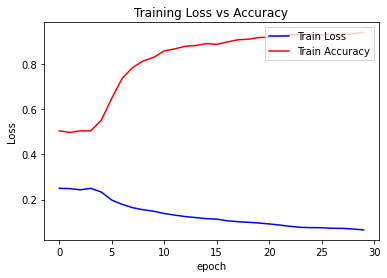

In [31]:
plt.plot(history.history["loss"],color='blue')
plt.plot(history.history["accuracy"],color='red')
plt.legend(["Train Loss", "Train Accuracy"], loc="upper right")
plt.title("Training Loss vs Accuracy")
plt.ylabel("Loss")
plt.xlabel("epoch")
plt.show()

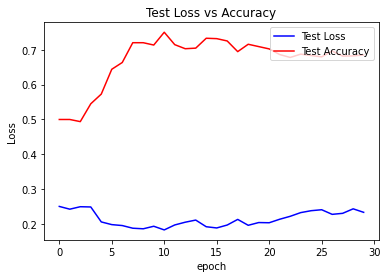

In [32]:
plt.plot(history.history["val_loss"],color='blue')
plt.plot(history.history["val_accuracy"],color='red')
plt.legend(["Test Loss", "Test Accuracy"], loc="upper right")
plt.title("Test Loss vs Accuracy")
plt.ylabel("Loss")
plt.xlabel("epoch")
plt.show()

In [ ]:
b